In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self):
        list_of_predict = {}
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
# folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_25/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.31246% 	8.85304% 	0.04888		0.04513		0.0		1.0	
(1024,256) 	95.4% 		0.47715% 	6.34738% 	0.82382		0.80845		0.0		0.97153	
(1024,1024) 	3.04% 		1.87167% 	2.30048% 	0.02452		0.00337		0.0		0.88847	


In [4]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(12548, 1.0) 0.65791 1.00000 0.34209 	(216335, 0.9354658055693996) 0.89219 0.93547 0.04327 	(243769, 0.8433451118963486) 0.15266 0.84335 0.69068 	
(10883, 1.0) 1.00000 1.00000 0.00000 	(214405, 0.9029693370681028) 0.88761 0.90297 0.01536 	(409230, 0.9281507656065962) 0.04856 0.92815 0.87960 	
(15621, 1.0) 0.99999 1.00000 0.00001 	(155270, 0.8262371486297759) 0.83986 0.82624 0.01363 	(25940, 0.9269729093050648) 0.10667 0.92697 0.82030 	
(69888, 1.0) 1.00000 1.00000 0.00000 	(212720, 0.9064655145665734) 0.86942 0.90647 0.03704 	(612566, 1.0) 0.03107 1.00000 0.96893 	
(11900, 1.0) 0.97383 1.00000 0.02617 	(179521, 0.8315766323732062) 0.84222 0.83158 0.01064 	(354387, 0.9034157832744406) 0.03060 0.90342 0.87282 	
(10900, 1.0) 0.94192 1.00000 0.05808 	(20663, 0.806652169568018) 0.75152 0.80665 0.05514 	(165371, 0.9599528857479388) 0.0

(1995, 1.0) 0.07237 1.00000 0.92763 	(187016, 0.8347607602840145) 0.83473 0.83476 0.00003 	(52252, 0.6383981154299176) 0.20118 0.63840 0.43722 	
(16000, 1.0) 1.00000 1.00000 0.00000 	(177980, 0.8983104068989888) 0.85322 0.89831 0.04509 	(444818, 0.7338044758539458) 0.07323 0.73380 0.66057 	
(59435, 1.0) 0.99999 1.00000 0.00001 	(120843, 0.9046319797305545) 0.86123 0.90463 0.04340 	(72766, 0.4994110718492344) 0.17599 0.49941 0.32342 	
(2818, 1.0) 0.94577 1.00000 0.05423 	(23590, 0.9261796214974586) 0.75372 0.92618 0.17246 	(162817, 0.8362779740871614) 0.27130 0.83628 0.56498 	
(17280, 1.0) 0.99991 1.00000 0.00009 	(253283, 0.8922292113978029) 0.86952 0.89223 0.02271 	(327872, 1.0) 0.02663 1.00000 0.97337 	
(33028, 1.0) 0.99809 1.00000 0.00191 	(45414, 0.8565180019498169) 0.84473 0.85652 0.01179 	(448791, 0.8904593639575972) 0.06619 0.89046 0.82427 	
(7959, 1.0) 0.96191 1.00000 0.03809 	(232837, 0.8689249689381701) 0.86656 0.86892 0.00237 	(180388, 0.38162544169611307) 0.07311 0.38163 0.

(24217, 1.0) 1.00000 1.00000 0.00000 	(182492, 0.8472740571149904) 0.84732 0.84727 0.00004 	(225415, 0.7879858657243817) 0.05214 0.78799 0.73585 	
(34432, 1.0) 0.99980 1.00000 0.00020 	(106845, 0.8455121033925073) 0.86185 0.84551 0.01634 	(331249, 0.9976442873969376) 0.01389 0.99764 0.98376 	
(17299, 1.0) 0.99984 1.00000 0.00016 	(144840, 0.8241077377869594) 0.84545 0.82411 0.02134 	(442399, 0.9305064782096585) 0.13432 0.93051 0.79619 	
(26138, 1.0) 0.99587 1.00000 0.00413 	(106022, 0.8076886960550264) 0.83248 0.80769 0.02479 	(384099, 0.9328621908127209) 0.03436 0.93286 0.89851 	
(523, 1.0) 0.22255 1.00000 0.77745 	(37806, 0.8906613353201591) 0.86102 0.89066 0.02964 	(361857, 0.955241460541814) 0.10181 0.95524 0.85343 	
(21119, 1.0) 0.99988 1.00000 0.00012 	(189760, 0.8453557115332219) 0.86656 0.84536 0.02120 	(27910, 0.8939929328621907) 0.07404 0.89399 0.81996 	
(7680, 1.0) 1.00000 1.00000 0.00000 	(217221, 0.9160125861464796) 0.90127 0.91601 0.01475 	(399406, 0.7997644287396938) 0.2

(85506, 1.0) 1.00000 1.00000 0.00000 	(214065, 0.8954995246083176) 0.89974 0.89550 0.00424 	(516402, 0.8374558303886925) 0.01710 0.83746 0.82036 	
(98048, 1.0) 1.00000 1.00000 0.00000 	(249273, 0.9001857476236177) 0.88086 0.90019 0.01932 	(349488, 0.4994110718492344) 0.04781 0.49941 0.45160 	
(50693, 1.0) 0.99101 1.00000 0.00899 	(63221, 0.877736927149812) 0.85679 0.87774 0.02095 	(58865, 0.872791519434629) 0.03342 0.87279 0.83937 	
(69380, 1.0) 0.99776 1.00000 0.00224 	(92825, 0.8338939085995041) 0.84394 0.83389 0.01005 	(407694, 0.9422850412249706) 0.04299 0.94229 0.89930 	
(72456, 1.0) 0.99976 1.00000 0.00024 	(169078, 0.8980718367930575) 0.86652 0.89807 0.03156 	(412268, 0.5182567726737338) 0.01895 0.51826 0.49931 	
(41604, 1.0) 0.99999 1.00000 0.00001 	(253275, 0.8940578792683279) 0.86815 0.89406 0.02591 	(308735, 0.9316843345111897) 0.07409 0.93168 0.85759 	
(8334, 1.0) 0.60265 1.00000 0.39735 	(101263, 0.8042684062195969) 0.83333 0.80427 0.02906 	(653404, 0.955241460541814) 0.01

(51195, 1.0) 1.00000 1.00000 0.00000 	(20188, 0.8707841686911527) 0.80925 0.87078 0.06153 	(121930, 0.877502944640754) 0.17599 0.87750 0.70152 	
(6527, 1.0) 0.99997 1.00000 0.00003 	(248217, 0.8730917000996902) 0.87113 0.87309 0.00196 	(127192, 0.6148409893992933) 0.09864 0.61484 0.51620 	
(4013, 1.0) 0.64963 1.00000 0.35037 	(259302, 0.8555516961849239) 0.82485 0.85555 0.03071 	(246453, 0.9528857479387515) 0.01767 0.95289 0.93521 	
(73375, 1.0) 1.00000 1.00000 0.00000 	(120673, 0.8511560612106036) 0.85331 0.85116 0.00215 	(69818, 0.9458186101295644) 0.14037 0.94582 0.80545 	
(3840, 1.0) 0.99617 1.00000 0.00383 	(234895, 0.8793130695938187) 0.86656 0.87931 0.01275 	(183967, 0.9988221436984688) 0.01432 0.99882 0.98450 	
(16791, 1.0) 0.99887 1.00000 0.00113 	(29774, 0.8346281048024511) 0.79800 0.83463 0.03663 	(29861, 0.9540636042402827) 0.13284 0.95406 0.82122 	
(32133, 1.0) 0.99996 1.00000 0.00004 	(219218, 0.9107880360407119) 0.89045 0.91079 0.02033 	(89208, 0.9269729093050648) 0.1759

(70400, 1.0) 1.00000 1.00000 0.00000 	(25741, 0.7922012077339452) 0.80145 0.79220 0.00924 	(148508, 0.917550058892815) 0.20118 0.91755 0.71637 	
(102914, 1.0) 1.00000 1.00000 0.00000 	(144582, 0.8446580038178133) 0.84631 0.84466 0.00165 	(22788, 0.9116607773851589) 0.12305 0.91166 0.78861 	
(21638, 1.0) 0.99680 1.00000 0.00320 	(174323, 0.8844547725575918) 0.86195 0.88445 0.02251 	(247947, 0.6054181389870436) 0.07788 0.60542 0.52754 	
(33026, 1.0) 0.98455 1.00000 0.01545 	(217108, 0.9314987820912577) 0.87324 0.93150 0.05826 	(66622, 0.011778563015312143) 0.17599 0.01178 0.16421 	
(48898, 1.0) 0.99979 1.00000 0.00021 	(159074, 0.9184365211732439) 0.86740 0.91844 0.05103 	(219346, 0.8044758539458187) 0.09243 0.80448 0.71205 	
(78083, 1.0) 1.00000 1.00000 0.00000 	(218144, 0.9154036565070757) 0.87540 0.91540 0.04000 	(475331, 0.4558303886925796) 0.03767 0.45583 0.41816 	
(93957, 1.0) 1.00000 1.00000 0.00000 	(185679, 0.8027749963565862) 0.81098 0.80277 0.00821 	(214640, 0.9434628975265018

(73730, 1.0) 1.00000 1.00000 0.00000 	(80801, 0.9520978524078444) 0.86811 0.95210 0.08399 	(77911, 0.9823321554770318) 0.17599 0.98233 0.80635 	
(78976, 1.0) 1.00000 1.00000 0.00000 	(109558, 0.8738948444434247) 0.86285 0.87389 0.01104 	(32971, 0.6713780918727915) 0.09076 0.67138 0.58062 	
(42895, 1.0) 0.95743 1.00000 0.04257 	(83377, 0.8340891895885157) 0.86437 0.83409 0.03028 	(559487, 0.9305064782096585) 0.04106 0.93051 0.88945 	
(60307, 1.0) 0.89597 1.00000 0.10403 	(199704, 0.8455813607134705) 0.84674 0.84558 0.00115 	(254067, 0.729093050647821) 0.15061 0.72909 0.57848 	
(57989, 1.0) 1.00000 1.00000 0.00000 	(190852, 0.8906199512672148) 0.86859 0.89062 0.02203 	(155658, 0.9623085983510011) 0.27994 0.96231 0.68237 	
(39046, 1.0) 0.98659 1.00000 0.01341 	(244990, 0.8798241899040783) 0.86882 0.87982 0.01100 	(327966, 1.0) 0.03543 1.00000 0.96457 	
(11274, 1.0) 0.85011 1.00000 0.14989 	(255462, 0.8806197892641944) 0.86656 0.88062 0.01406 	(107092, 0.7314487632508835) 0.07524 0.73145 0

(91141, 1.0) 0.99998 1.00000 0.00002 	(219452, 0.9074322442784092) 0.90955 0.90743 0.00212 	(182484, 0.19316843345111895) 0.07373 0.19317 0.11944 	
(68739, 1.0) 0.99979 1.00000 0.00021 	(40047, 0.8734013333605464) 0.81821 0.87340 0.05519 	(218206, 0.8928150765606597) 0.06849 0.89282 0.82433 	
(1789, 1.0) 0.85700 1.00000 0.14300 	(163061, 0.8616250907137145) 0.85859 0.86163 0.00304 	(197800, 0.082449941107185) 0.08756 0.08245 0.00511 	
(6549, 1.0) 0.97552 1.00000 0.02448 	(121773, 0.8842500241605081) 0.86629 0.88425 0.01796 	(259166, 0.16489988221436983) 0.08582 0.16490 0.07908 	
(52873, 1.0) 1.00000 1.00000 0.00000 	(19116, 0.8634157251891234) 0.82690 0.86342 0.03651 	(550020, 0.751472320376914) 0.03578 0.75147 0.71569 	
(83843, 1.0) 1.00000 1.00000 0.00000 	(253278, 0.8892324631457237) 0.86725 0.88923 0.02198 	(72704, 0.96113074204947) 0.30778 0.96113 0.65335 	
(13819, 1.0) 1.00000 1.00000 0.00000 	(161104, 0.8618250217160955) 0.85669 0.86183 0.00514 	(167535, 0.9163722025912839) 0.01

(46117, 1.0) 0.90331 1.00000 0.09669 	(106372, 0.8221520778461027) 0.85599 0.82215 0.03384 	(252099, 0.9528857479387515) 0.03868 0.95289 0.91420 	
(39682, 1.0) 1.00000 1.00000 0.00000 	(224281, 0.9109522351640502) 0.88992 0.91095 0.02103 	(88072, 0.7667844522968199) 0.27806 0.76678 0.48872 	
(48139, 1.0) 0.98937 1.00000 0.01063 	(49286, 0.8324512976697264) 0.81813 0.83245 0.01433 	(751325, 1.0) 0.00843 1.00000 0.99157 	
(6042, 1.0) 0.90274 1.00000 0.09726 	(134059, 0.8905719863571515) 0.86360 0.89057 0.02697 	(810075, 0.9293286219081272) 0.02021 0.92933 0.90912 	
(7804, 1.0) 1.00000 1.00000 0.00000 	(122569, 0.8562841098168796) 0.86614 0.85628 0.00986 	(278033, 0.9116607773851589) 0.03022 0.91166 0.88144 	
(1021, 1.0) 0.83902 1.00000 0.16098 	(194776, 0.8730239445406317) 0.86656 0.87302 0.00647 	(542251, 0.751472320376914) 0.04755 0.75147 0.70392 	
(17925, 1.0) 0.98226 1.00000 0.01774 	(28816, 0.8758584436353964) 0.82076 0.87586 0.05510 	(366228, 0.5406360424028269) 0.01547 0.54064 0.5

(14388, 1.0) 0.99737 1.00000 0.00263 	(27245, 0.8470448909998977) 0.80375 0.84704 0.04329 	(377406, 0.9835100117785631) 0.06687 0.98351 0.91664 	
(9980, 1.0) 0.99995 1.00000 0.00005 	(60394, 0.9058447930374877) 0.85352 0.90584 0.05233 	(39305, 0.8998822143698468) 0.17365 0.89988 0.72624 	
(91162, 1.0) 0.99999 1.00000 0.00001 	(137600, 0.8660457035586878) 0.86457 0.86605 0.00148 	(534076, 0.9293286219081272) 0.03773 0.92933 0.89159 	
(1959, 1.0) 0.07237 1.00000 0.92763 	(240689, 0.8807657339459805) 0.86656 0.88077 0.01421 	(166049, 0.5323910482921084) 0.09710 0.53239 0.43529 	
(8980, 1.0) 0.83544 1.00000 0.16456 	(47267, 0.8644678678912641) 0.85169 0.86447 0.01277 	(420286, 0.7526501766784454) 0.02069 0.75265 0.73196 	
(3089, 1.0) 0.70341 1.00000 0.29659 	(168737, 0.8612040327413324) 0.85413 0.86120 0.00707 	(7404, 0.6537102473498233) 0.20651 0.65371 0.44720 	
(8093, 1.0) 0.89962 1.00000 0.10038 	(162021, 0.9034801647840691) 0.86681 0.90348 0.03667 	(4181, 0.4994110718492344) 0.33537 0.

(57216, 1.0) 0.99999 1.00000 0.00001 	(175420, 0.9147938031614016) 0.85137 0.91479 0.06342 	(203558, 0.5406360424028269) 0.01148 0.54064 0.52915 	
(75394, 1.0) 1.00000 1.00000 0.00000 	(260332, 0.8786302565214212) 0.81963 0.87863 0.05900 	(193690, 0.8987043580683157) 0.09009 0.89870 0.80861 	
(21384, 1.0) 0.99777 1.00000 0.00223 	(100349, 0.8211982634063497) 0.81502 0.82120 0.00617 	(461248, 0.8244994110718493) 0.13892 0.82450 0.68558 	
(6546, 1.0) 0.99671 1.00000 0.00329 	(29171, 0.7927274988324993) 0.85167 0.79273 0.05894 	(82476, 0.9458186101295644) 0.48610 0.94582 0.45972 	
(36305, 1.0) 1.00000 1.00000 0.00000 	(38185, 0.7992591322561989) 0.80416 0.79926 0.00490 	(545290, 1.0) 0.02569 1.00000 0.97431 	
(21884, 1.0) 1.00000 1.00000 0.00000 	(190282, 0.925293602112906) 0.85604 0.92529 0.06925 	(217109, 0.762073027090695) 0.24197 0.76207 0.52010 	
(9372, 1.0) 0.91227 1.00000 0.08773 	(67614, 0.8920272081157906) 0.86230 0.89203 0.02973 	(250109, 0.9305064782096585) 0.05967 0.93051 0.87

(54814, 1.0) 1.00000 1.00000 0.00000 	(132617, 0.8086058495134236) 0.86449 0.80861 0.05588 	(55014, 0.6360424028268551) 0.02461 0.63604 0.61144 	
(119041, 1.0) 1.00000 1.00000 0.00000 	(97160, 0.8679050080785305) 0.85686 0.86791 0.01105 	(147611, 0.9729093050647822) 0.15592 0.97291 0.81699 	
(86018, 1.0) 1.00000 1.00000 0.00000 	(11350, 0.7598573475809194) 0.36097 0.75986 0.39889 	(684536, 0.8645465253239106) 0.04630 0.86455 0.81825 	
(25512, 1.0) 0.84642 1.00000 0.15358 	(33301, 0.7741160775997067) 0.75241 0.77412 0.02170 	(103853, 0.8857479387514724) 0.02369 0.88575 0.86206 	
(112000, 1.0) 1.00000 1.00000 0.00000 	(232669, 0.8741395778955927) 0.86656 0.87414 0.00758 	(268386, 0.7550058892815077) 0.09585 0.75501 0.65916 	
(29476, 1.0) 0.99957 1.00000 0.00043 	(214088, 0.9105646330043087) 0.86426 0.91056 0.04631 	(67719, 0.9316843345111897) 0.17635 0.93168 0.75533 	
(111360, 1.0) 1.00000 1.00000 0.00000 	(228524, 0.8666738391119791) 0.86656 0.86667 0.00012 	(643775, 0.8763250883392227)

(53515, 1.0) 1.00000 1.00000 0.00000 	(92275, 0.889128842490773) 0.86659 0.88913 0.02253 	(61453, 0.7997644287396938) 0.27851 0.79976 0.52126 	
(7816, 1.0) 0.99998 1.00000 0.00002 	(166687, 0.8590555497138281) 0.84586 0.85906 0.01319 	(22859, 1.0) 0.11353 1.00000 0.88647 	
(105985, 1.0) 1.00000 1.00000 0.00000 	(170739, 0.8549149744516339) 0.85516 0.85491 0.00025 	(105690, 0.5206124852767963) 0.04956 0.52061 0.47105 	
(85248, 1.0) 1.00000 1.00000 0.00000 	(140881, 0.8663902007329028) 0.86140 0.86639 0.00499 	(142809, 0.9093050647820966) 0.08693 0.90931 0.82237 	
(26371, 1.0) 1.00000 1.00000 0.00000 	(248949, 0.8940071614963769) 0.87730 0.89401 0.01671 	(631393, 0.9458186101295644) 0.70749 0.94582 0.23833 	
(45696, 1.0) 0.99989 1.00000 0.00011 	(163146, 0.8551846467357593) 0.86538 0.85518 0.01020 	(194717, 0.9363957597173145) 0.10477 0.93640 0.83162 	
(24316, 1.0) 0.99997 1.00000 0.00003 	(84501, 0.8761944307789263) 0.84436 0.87619 0.03183 	(563520, 0.9493521790341579) 0.02905 0.94935 0

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


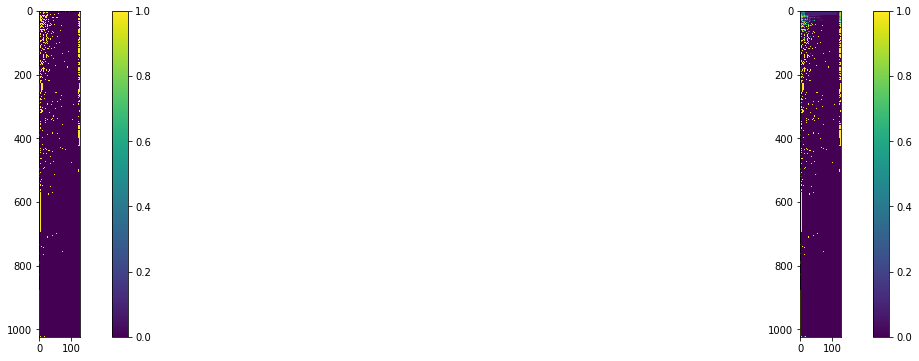

3.4116707e-10
0.9715341


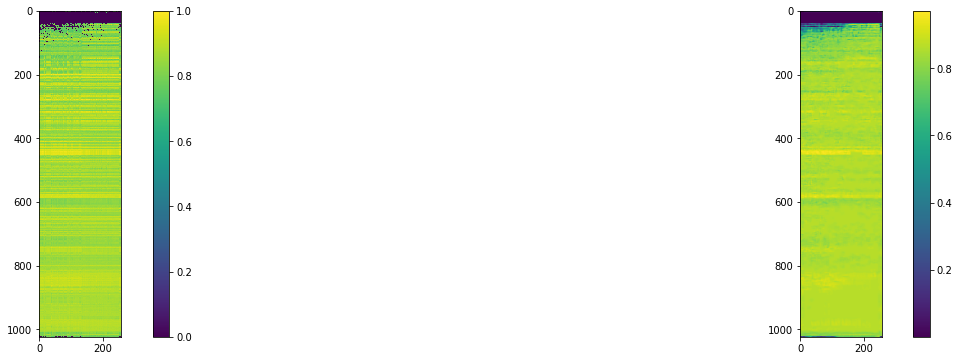

1.00378195e-07
0.8884662


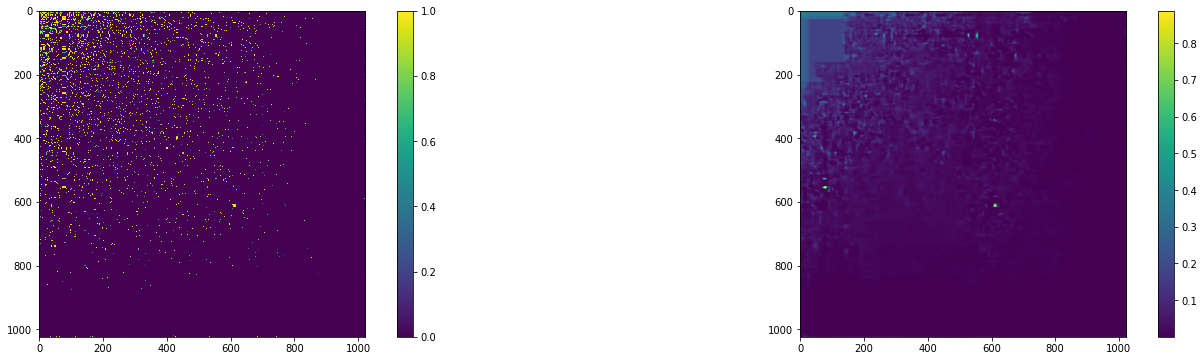

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/_00/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
# color_pack2 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

#     ax = axes[2]
#     im = ax.imshow(predict - org_data, vmin=-1, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    
    plt.savefig(path + 'experiment' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


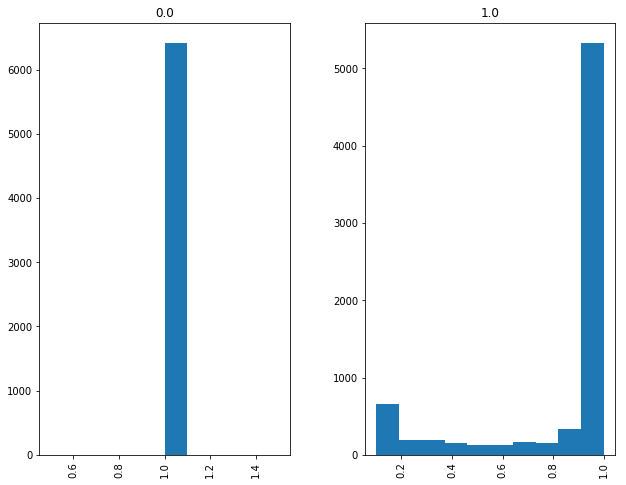

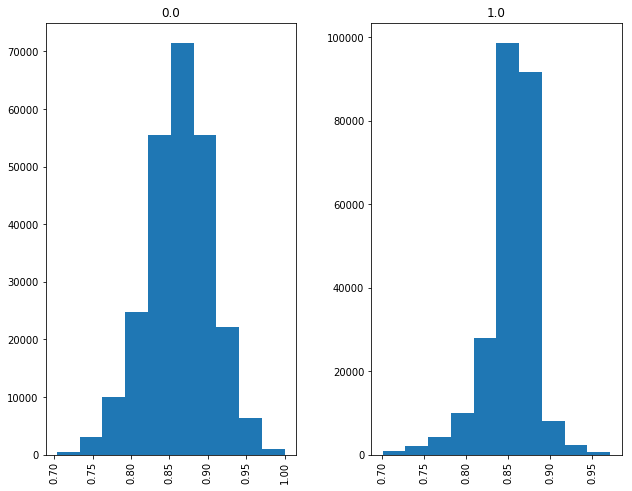

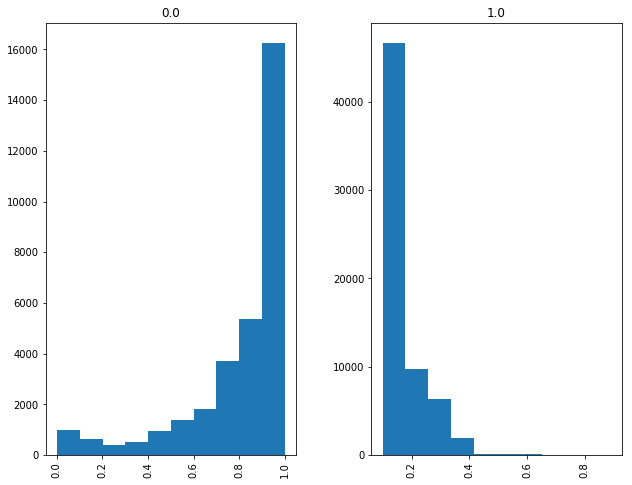

In [6]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    df = pd.DataFrame(data)
    df.hist(by=indeces, bins=10, figsize=(10, 8))
    

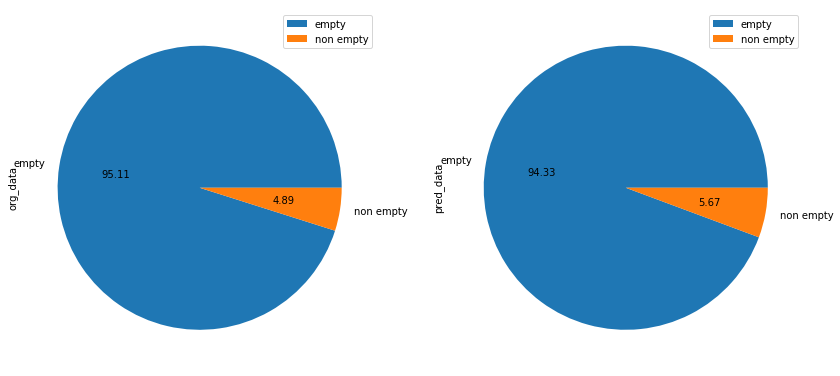

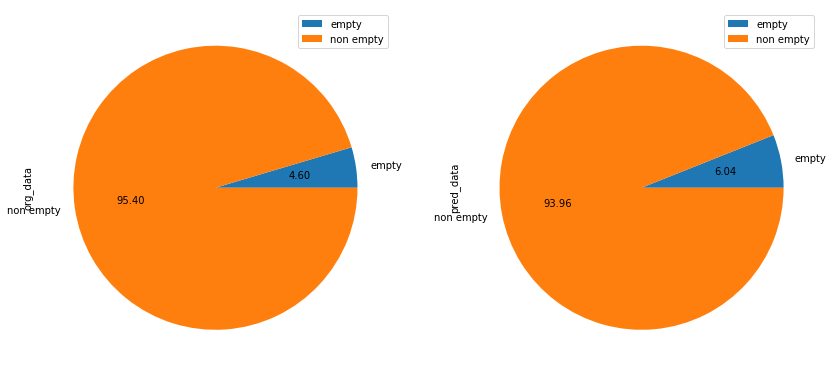

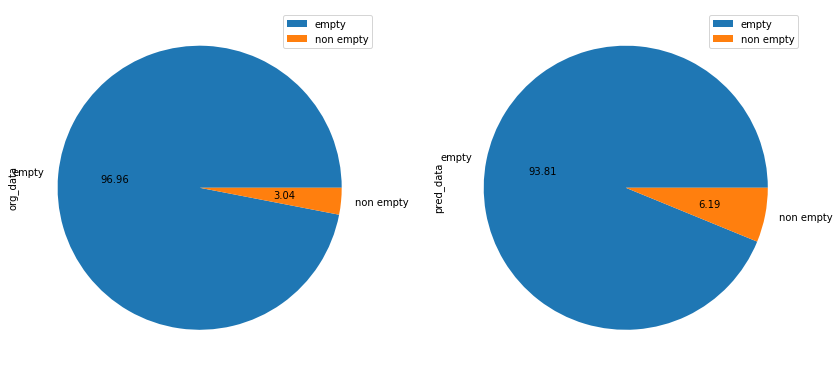

In [7]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    length = len(org_data)
    d = {}
    d['org_data'] = []
    d['org_data'].append(len(org_data[org_data == 0]) / length)
    d['org_data'].append(len(org_data[org_data > 0]) / length)

    if i == 1:
        d['pred_data'] = []
        d['pred_data'].append(len(pred_data[pred_data <= 0.7]) / length)
        d['pred_data'].append(len(pred_data[pred_data > 0.7]) / length)
    else:
        d['pred_data'] = []
        d['pred_data'].append(len(pred_data[pred_data <= 0.1]) / length)
        d['pred_data'].append(len(pred_data[pred_data > 0.1]) / length)

    df = pd.DataFrame(d, index=['empty', 'non empty'])
    plot = df.plot.pie(subplots=True, figsize=(14, 8), autopct='%.2f')


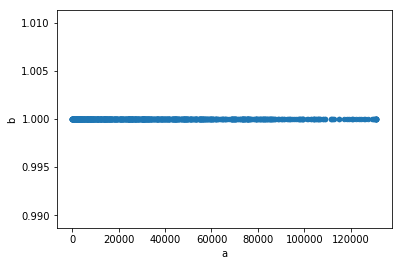

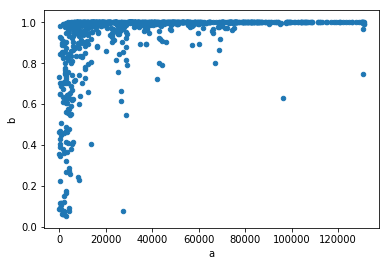

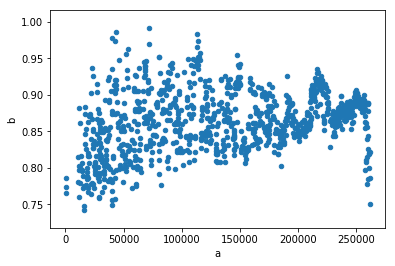

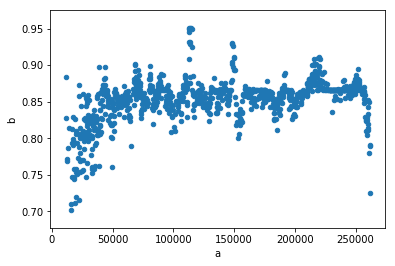

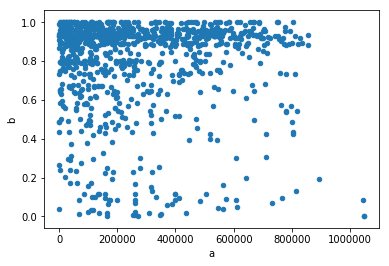

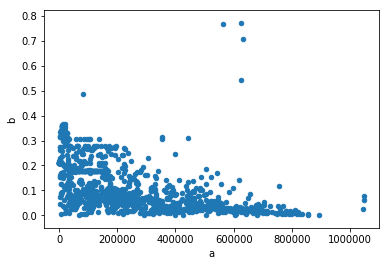

In [8]:
for i in range(len(model.org_data)):
    # df.plot.scatter(x='a', y='b');
    # print(np.random.rand(50, 4))
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    # print(data)
    new_org_data = []
    new_predict_data = []
    for j in range(len(org_data)):
        if i == 1:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            if predict_data[j][1] > 0.7:
                new_predict_data.append([predict_data[j][0], predict_data[j][1]])
        else:
            new_org_data.append([org_data[j][0], org_data[j][1]])
            new_predict_data.append([predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(new_org_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    df = pd.DataFrame(new_predict_data, columns=['a', 'b'])
    df.plot.scatter(x='a', y='b');

    new_predict_data

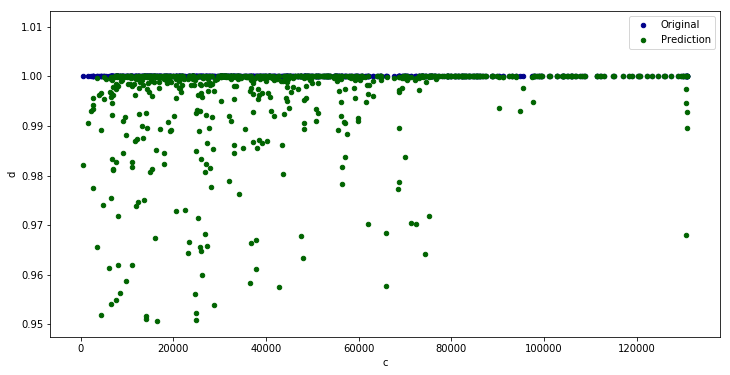

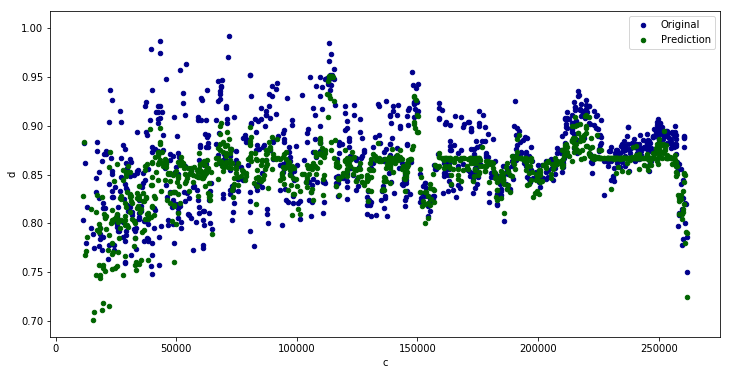

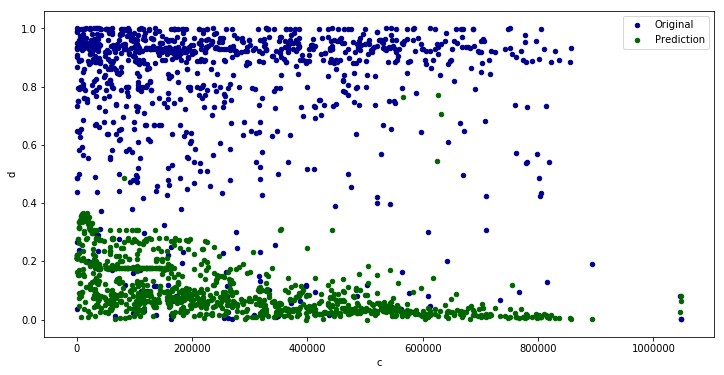

In [9]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original');
    df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));

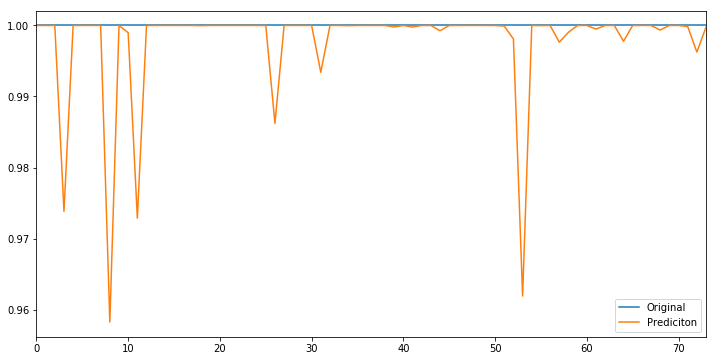

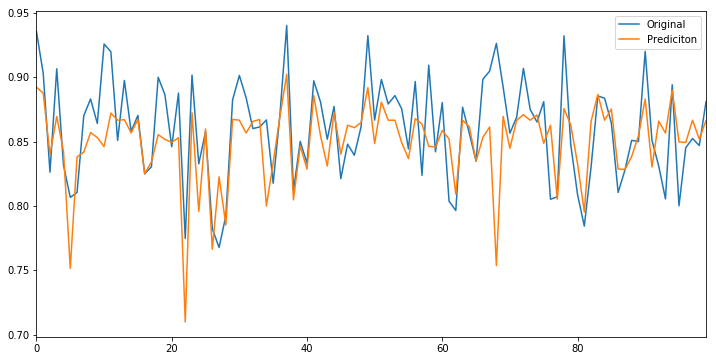

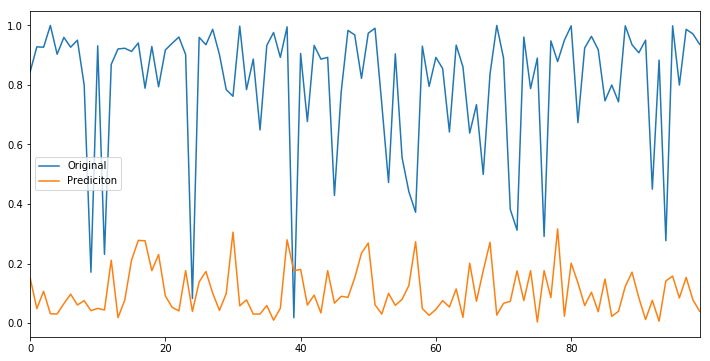

In [10]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data[:100])):
        if i == 0:
            if predict_data[j][1] > 0.95:
#                 data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
                data.append([org_data[j][1], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
#                 data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
                data.append([org_data[j][1], predict_data[j][1]])
        else:
#             data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
            data.append([org_data[j][1], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['Original', 'Prediciton'])
    
#     ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original');
#     df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
    df.plot(subplots=False, figsize=(12,6));